In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)

scipy: 1.4.1
numpy: 1.18.1
matplotlib: 3.1.3
pandas: 1.0.1
sklearn: 0.22.1
statsmodels: 0.11.0


In [2]:
# separate out a validation dataset
from pandas import read_csv
series = read_csv('MonthlySales_Modified.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 36, Validation 12


In [3]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=24797.289, Expected=28765
>Predicted=28765.330, Expected=36898
>Predicted=36898.328, Expected=64596
>Predicted=64595.922, Expected=31405
>Predicted=31404.920, Expected=75973
>Predicted=75972.562, Expected=74920
>Predicted=74919.523, Expected=18542
>Predicted=18542.490, Expected=22868
>Predicted=22867.711, Expected=51186
>Predicted=51186.219, Expected=39249
>Predicted=39248.590, Expected=56691
>Predicted=56691.078, Expected=39430
>Predicted=39430.441, Expected=38441
>Predicted=38440.762, Expected=33266
>Predicted=33265.559, Expected=72908
>Predicted=72908.109, Expected=56463
>Predicted=56463.129, Expected=82192
>Predicted=82192.320, Expected=97237
RMSE: 25210.055


In [4]:
from pandas import read_csv
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
print(series.describe())

count       36.000000
mean     43423.718056
std      23371.744332
min       4519.890000
25%      28198.880000
50%      35746.730000
75%      58667.290000
max      97237.420000
Name: 1, dtype: float64


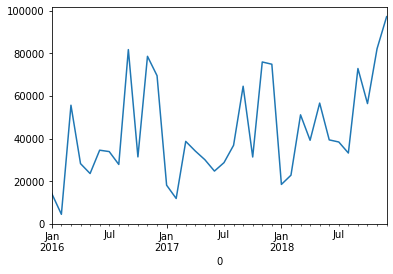

In [5]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
series.plot()
pyplot.show()

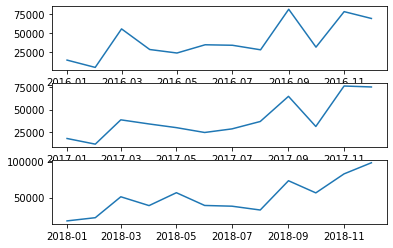

In [6]:
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series['2016':'2018'].groupby(Grouper(freq='A'))
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
	pyplot.subplot((n_groups*100) + 10 + i)
	i += 1
	pyplot.plot(group)
pyplot.show()

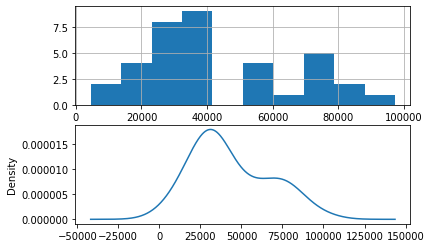

In [7]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

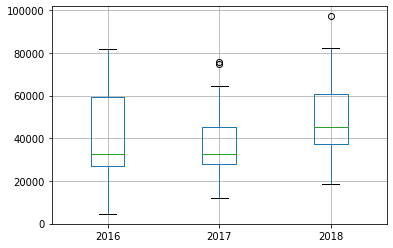

In [8]:
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series['2015':'2018'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show()

ADF Statistic: 0.829513
p-value: 0.992098
Critical Values:
	1%: -4.012
	5%: -3.104
	10%: -2.691


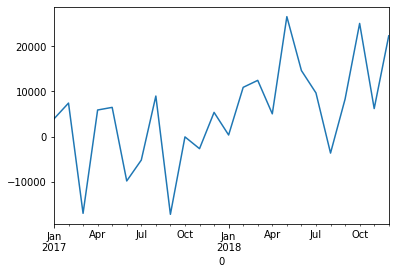

In [9]:
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)
# plot
stationary.plot()
pyplot.show()

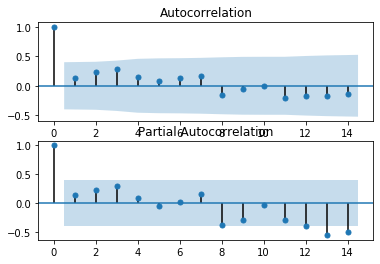

In [10]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = read_csv('stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

In [11]:
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=13994.183
ARIMA(0, 1, 1) RMSE=10866.497
ARIMA(1, 0, 0) RMSE=13003.064
ARIMA(1, 1, 0) RMSE=11516.048
ARIMA(1, 2, 0) RMSE=17968.142
Best ARIMA(0, 1, 1) RMSE=10866.497


0
count     18.000000
mean    5153.765615
std    13387.802371
min   -17143.369431
25%    -3958.675159
50%     5561.148056
75%    14368.866437
max    27576.532185


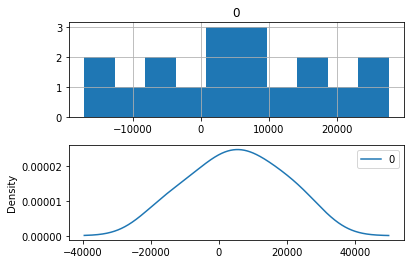

In [12]:
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

RMSE: 13010.605
                  0
count  1.800000e+01
mean  -1.226403e-07
std    1.338780e+04
min   -2.229714e+04
25%   -9.112441e+03
50%    4.073824e+02
75%    9.215101e+03
max    2.242277e+04


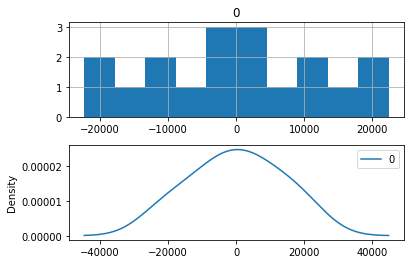

In [13]:
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 5153.765615
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

0
count     18.000000
mean    5153.765615
std    13387.802371
min   -17143.369431
25%    -3958.675159
50%     5561.148056
75%    14368.866437
max    27576.532185


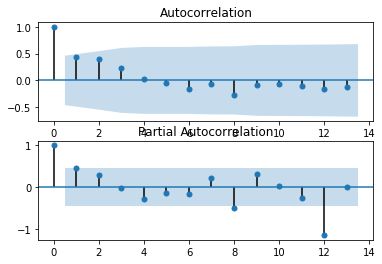

In [14]:
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

In [15]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 5153.765615
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [16]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 28077.123


>Predicted=28077.123, Expected=44703
>Predicted=33975.366, Expected=20301
>Predicted=53978.084, Expected=58872
>Predicted=46930.212, Expected=36522
>Predicted=60595.154, Expected=44261
>Predicted=41651.798, Expected=52982
>Predicted=47341.468, Expected=45264
>Predicted=39113.991, Expected=63121
>Predicted=84906.783, Expected=87867
>Predicted=63523.433, Expected=77777
>Predicted=92565.444, Expected=118448
>Predicted=112700.576, Expected=83829
RMSE: 16550.144


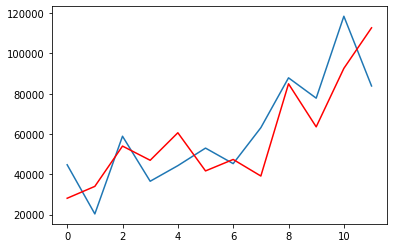

In [17]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()